# Bayesian Workflow: Modeling COVID-19

Strengths of Bayesian statistics that are critical here:
* Great flexibility to quickly and iteratively build statistical models
* Offers principled way of dealing with uncertainty
* Don't just want most likely outcome but distribution of all possible outcomes
* Allows expert information to guide model by using informative priors

In this lecture you'll learn:
* How to go from data to a model idea
* How to find priors for your model
* How to evaluate a model
* How to iteratively improve a model
* How to forecast into the future
* How powerful generative modeling can be

In [1]:
import load_covid_data
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import warnings
warnings.simplefilter("ignore")

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {"chains": 4, "cores": 4, "return_inferencedata": True}

## Load data

First we'll load data on COVID-19 cases from the WHO. In order to ease analysis we will remove any days were confirmed cases was below 100 (as reporting is often very noisy in this time-frame). It also allows us to align countries with each other for easier comparison.

In [2]:
df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]
df.head()

,country,state,type,confirmed,critical_estimate,days_since_100,deaths
date,,,,,,,
2020-03-27,Afghanistan,NaN,confirmed,110,5.5,0.0,4
2020-03-28,Afghanistan,NaN,confirmed,110,5.5,1.0,4
2020-03-29,Afghanistan,NaN,confirmed,120,6.0,2.0,4
2020-03-30,Afghanistan,NaN,confirmed,170,8.5,3.0,4
2020-03-31,Afghanistan,NaN,confirmed,174,8.7,4.0,4


## Bayesian Workflow

Next, we will start developing a model of the spread. These models will start out simple and bad but we will iteratively improve them. A good workflow to adopt when developing your own models is:

1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence
6. Run posterior predictive check
7. Improve model

### 1. Plot the data

We will look at German COVID-19 cases. At first, we will only look at the first 30 days after Germany crossed 100 cases, later we will look at the full data.

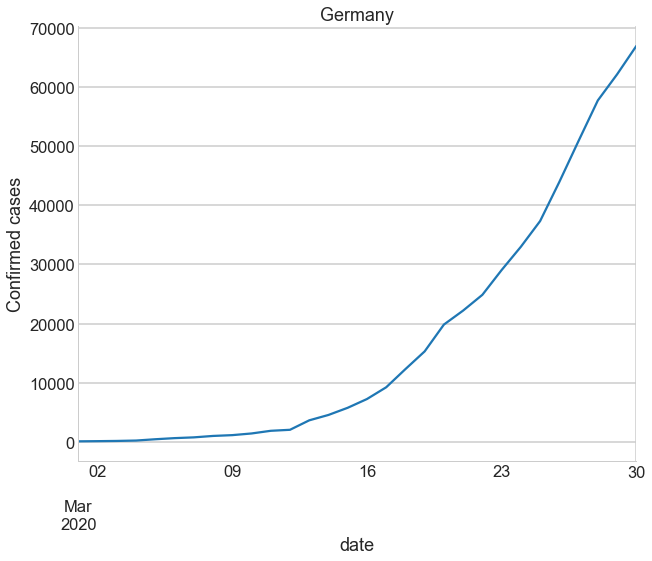

In [37]:
country = 'Germany'
df_country = df.loc[lambda x: (x.country == country)].iloc[:30]

fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()

Look at the above plot and think of what type of model you would build to model the data.

### 2. Build model

The above line kindof looks like an exponential. This matches with knowledge from epidemiology whereas early in an epidemic it grows exponentially.

In [5]:
# Get time-range of days since 100 cases were crossed
t = df_country.days_since_100.values
# Get number of confirmed cases for Germany
confirmed = df_country.confirmed.values

with pm.Model() as model_exp1:
    # Intercept
    a = pm.Normal('a', mu=0, sigma=100)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal('eps', 100)

    # Likelihood
    pm.Normal('obs',
              mu=growth,
              sigma=eps,
              observed=confirmed)

Just looking at the above model, what do you think? Is there anything you would have done differently?

## 3. Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

The process works as follows:

1. Pick a point from the prior $\theta_i$
2. Generate data set $x_i \sim f(\theta_i)$ where $f$ is our likelihood function (e.g. normal).
3. Rinse and repeat $n$ times.

In [6]:
with model_exp1:
    prior_pred = pm.sample_prior_predictive()

[(-1000.0, 1000.0),
 Text(0, 0.5, 'Positive cases'),
 (0.0, 10.0),
 Text(0.5, 0, 'Days since 100 cases'),
 Text(0.5, 1.0, 'Prior predictive')]

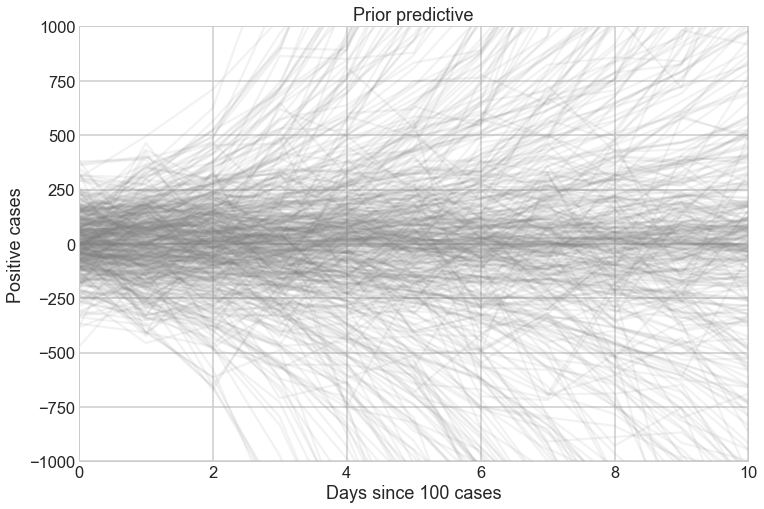

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1)
ax.set(ylim=(-1000, 1000),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

Does this look sensible? Why or why not? List the issues you can identify from this prior predictive.

Despite these concerns, let's try and fit the model:

In [8]:
with model_exp1:
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


RuntimeError: Chain 0 failed.

Add visual for mass matrix.

When working with Bayesian models, chances are you will encounter these crytpic error messages frequently. From the previous lecture some of those terms should ring familiar. Apparently there are zeros on the diagonal of the *mass matrix*. If you recall, the mass matrix is used for the proposal of the *kinetic energy*. This matrix is estimated during the tuning step based on the samples we have so far collected. 

Something went wrong in that tuning process. It is sometimes instructive to look at a short trace that didn't fail.

In [9]:
with model_exp1:
    trace = pm.sample(tune=0, draws=500,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a]


Sampling 2 chains for 0 tune and 500 draw iterations (0 + 1_000 draws total) took 1 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


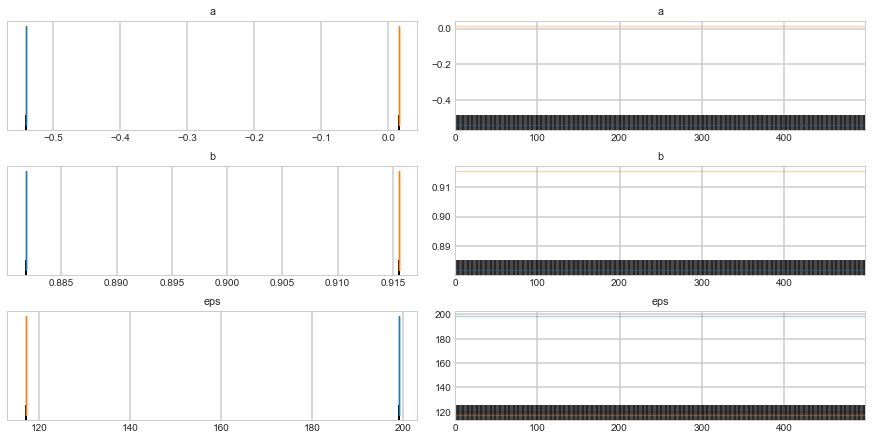

In [10]:
az.plot_trace(trace);

As you can see, the trace is just a flat line. This means, the sampler is not making any moves. So then when you try to compute the (diagonal) covariance matrix from this the variance will be zero, which explains the error message.

During sampling we also got the error message that there are only divergent samples and that our model is probably misspecified.

This brings us to Gelman's "Folk Theorem of Statistical Computing": If you have trouble sampling, most likely you have a bad model.

Note that, while these errors can be annoying, this is a huge benefit: **The sampler wants to tell you that your model is misspecified.** This by far beats the alternative where you can fit a Machine Learning model that does not do anything sensible but still fits just fine.

### What's wrong with this model?

Above you hopefully identified a few issues with this model:
1. Cases can't be negative
2. Cases can not start at 0, as we set it to start at above 100.
3. Positive cases can not go down

Let's improve upon this. That the number of cases goes negative is due to us using a Normal likelihood. Instead, let's use a *Negative Binomial*, which is similar to *Poisson* which is commonly used for count-data but has an extra dispersion parameter that allows more flexiblity in modeling the variance of the data.

We will also change the prior of the intercept to be centered at 100 and tighten the prior of the slope.

In [11]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values

with pm.Model() as model_exp2:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed)

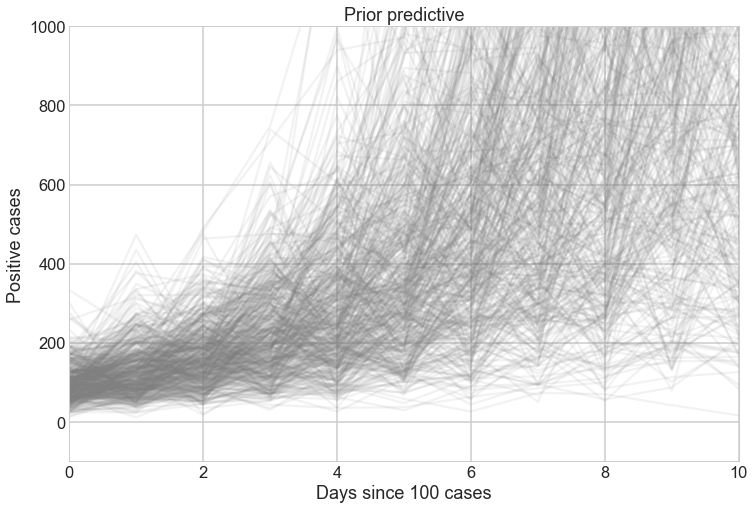

In [12]:
with model_exp2:
    prior_pred = pm.sample_prior_predictive()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1)
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

In [13]:
with model_exp2:
    trace_exp2 = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


That looks much better. However, we can include even more prior information. For example, we know that the intercept *can not* be below 100 because of how we sliced the data. We can thus create a prior that does not have probability mass below 100. For this, we use the PyMC3 `Bound` class that can arbitrarily bound probability distributions. We can apply the same for the slope which we know is not going to be negative.

In [14]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values

with pm.Model() as model_exp3:
    # Intercept
    BoundNormal_100 = pm.Bound(pm.Normal, lower=100)
    a = BoundNormal_100('a', mu=100, sigma=25)

    # Slope
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    b = BoundNormal_0('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed)
    
    prior_pred = pm.sample_prior_predictive()

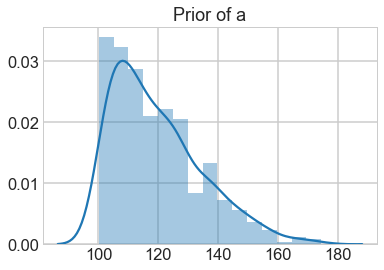

In [15]:
sns.distplot(prior_pred['a']);
plt.title('Prior of a');

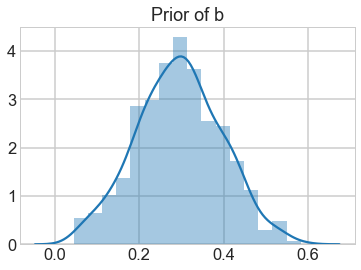

In [16]:
sns.distplot(prior_pred['b']);
plt.title('Prior of b');

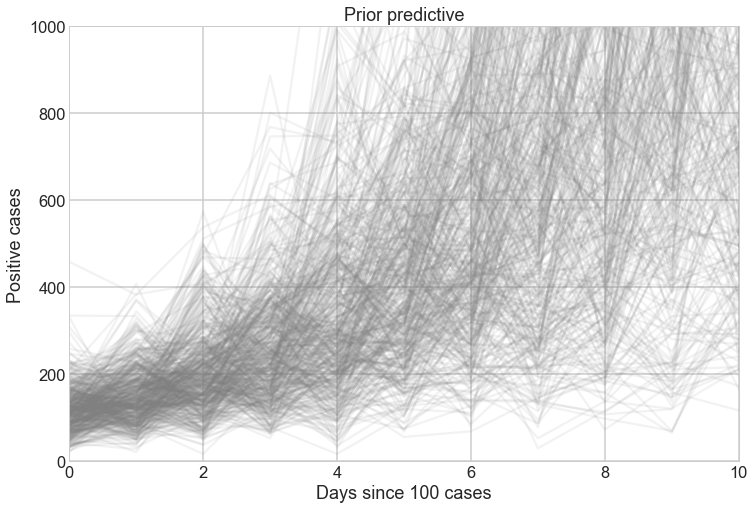

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1)
ax.set(ylim=(0, 1000),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

Note that even though the intercept parameter can not be below 100 now, we still see data generated at below hundred. Why? 

## 4. Fit model

In [18]:
with model_exp3:
    # Inference button (TM)
    trace_exp3 = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


## 5. Assess convergence

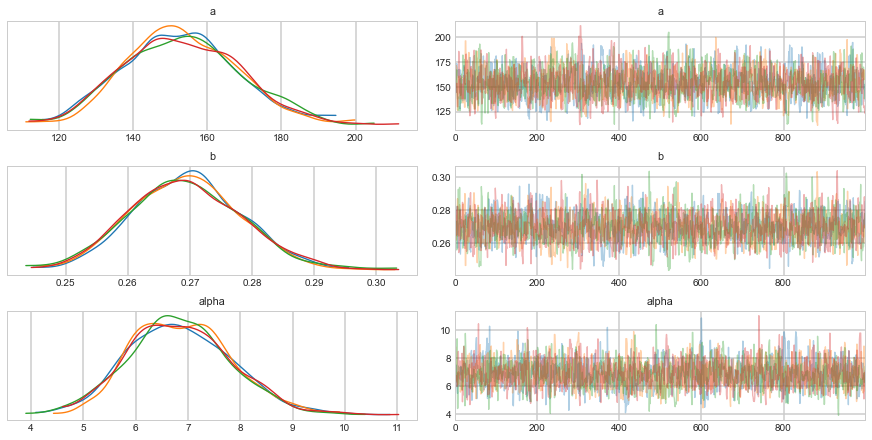

In [19]:
az.plot_trace(trace_exp3);

In [20]:
az.summary(trace_exp3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,153.259,15.439,125.580,182.594,0.369,0.263,1748.0,1727.0,1748.0,1578.0,1.0
b,0.269,0.009,0.252,0.285,0.000,0.000,1834.0,1834.0,1825.0,1440.0,1.0
alpha,6.873,0.976,5.058,8.612,0.022,0.016,2016.0,1973.0,2042.0,1864.0,1.0


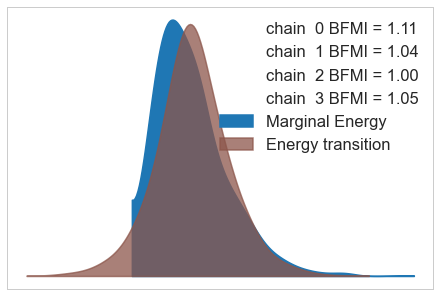

In [21]:
az.plot_energy(trace_exp3);

### Model comparison

Let's quickly compare the two models we were able to sample from:

In [22]:
az.compare({"exp2": trace_exp2, "exp3": trace_exp3})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
exp3,0,-265.093,1.33709,0,0.508206,12.0512,0,False,log
exp2,1,-265.127,1.33934,0.0346884,0.491794,12.079,0.0442595,False,log


It seems like bounding the priors did not result in better fit. This is not unexpected because our change in prior was very small. We will still continue with `model_exp3` because we have prior information that these parameters are bounded in this way.

### 6. Run posterior predictive check

Similar to the prior predictive, we can also generate new data by repeatedly taking samples from the posterior and generating data using these parameters.

In [23]:
with model_exp3:
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_exp3.posterior)

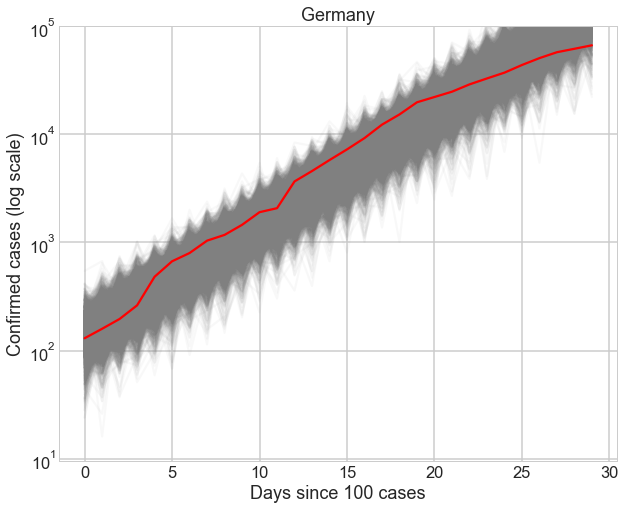

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['obs'].T, color='0.5', alpha=.05)
ax.plot(confirmed, color='r', label='data')
ax.set(xlabel="Days since 100 cases", 
       ylabel="Confirmed cases (log scale)",
       ylim=(0, 100_000), title=country, 
       yscale="log");

OK, that does not look terrible, the data is at least inside of what the model can produce. Let's look at residuals for systematic errors:

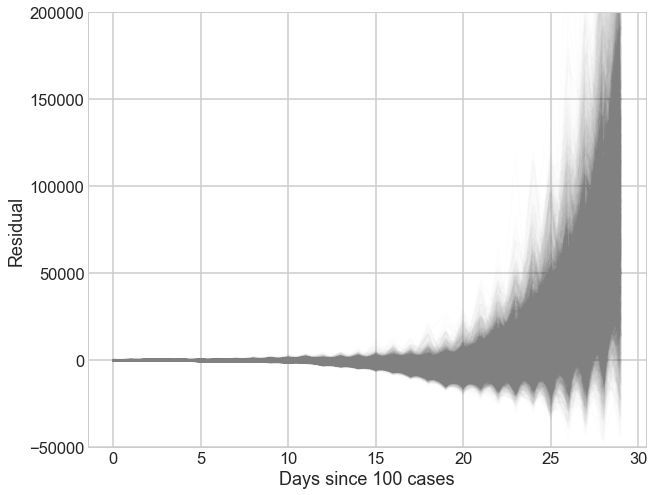

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
resid = post_pred["obs"] - confirmed
ax.plot(resid.T, color="0.5", alpha=.01);
ax.set(ylim=(-50_000, 200_000), ylabel="Residual",
       xlabel="Days since 100 cases");

What can you see?

### Prediction and forecasting

We might also be interested in predicting on unseen or data, or, in the case time-series data like here, in forecasting. In `PyMC3` you can do so easily using `pm.Data`. What it allows you to do is define data to a PyMC3 model that you can later switch out for other data. That way, when you for example do posterior predictive sampling, it will generate samples into the future.

Let's change our model to use `pm.Data` instead.

In [26]:
with pm.Model() as model_exp4:
    # pm.Data needs to be in the model context so that we can
    # keep track of it.
    # Then, we can then use it like any other array.
    t_data = pm.Data('t', df_country.days_since_100.values)
    confirmed_data = pm.Data('confirmed', df_country.confirmed.values)

    # Intercept
    BoundNormal_100 = pm.Bound(pm.Normal, lower=100)
    a = BoundNormal_100('a', mu=100, sigma=25)

    # Slope
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    b = BoundNormal_0('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t_data

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed_data)
    
    trace_exp4 = pm.sample(**sampler_kwargs)

In [27]:
with model_exp3:
    # Update our data containers.
    # Note that because confirmed is observed, we do not
    # need to specify any data, as that is only needed
    # during inference. But do have to update it to match
    # the shape.
    pm.set_data({'t': np.arange(60),
                 'confirmed': np.zeros(60, dtype='int')})

    post_pred = pm.sample_posterior_predictive(trace_exp4.posterior)

As we held data back before, we can now see how the predictions of the model

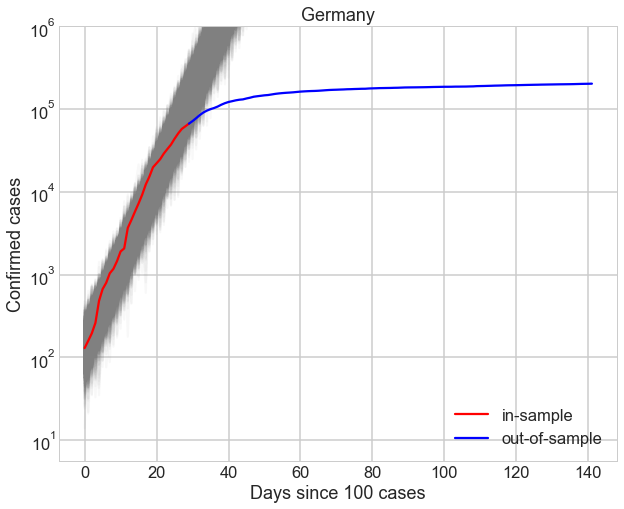

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['obs'].T, color='0.5', alpha=.05)
ax.plot(df_country.confirmed.values, color='r', label="in-sample")
df_confirmed = df.loc[lambda x: (x.country == country), 'confirmed']
ax.plot(np.arange(29, len(df_confirmed)), df_confirmed.iloc[29:].values,
        color='b', label="out-of-sample")
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       ylim=(0, 1_000_000), title=country, yscale="log");
ax.legend();

## 7. Improve model

### Logistic model

<img src="https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/924/2015/11/25202016/CNX_Precalc_Figure_04_07_0062.jpg"/>

In [66]:
df_country = df.loc[lambda x: (x.country == country)]

with pm.Model() as logistic_model:
    t_data = pm.Data('t', df_country.days_since_100.values)
    confirmed_data = pm.Data('confirmed', df_country.confirmed.values)

    # Intercept
    BoundNormal_100 = pm.Bound(pm.Normal, lower=100)
    intercept = BoundNormal_100('a', mu=100, sigma=25)
    
    # Slope
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    b = BoundNormal_0('b', mu=0.3, sigma=0.1)
    
    carrying_capacity = pm.Uniform('carrying_capacity',
                                   lower=1_000,
                                   upper=80_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed_data)
    
    prior_pred = pm.sample_prior_predictive()

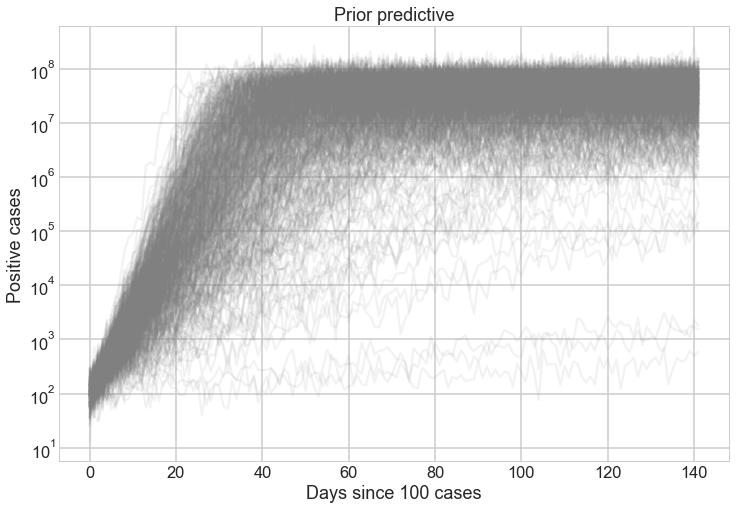

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1)
ax.set(title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases",
       yscale="log",
);

In [68]:
with logistic_model:
    # Inference
    trace_logistic = pm.sample(**sampler_kwargs, target_accept=0.9)
    
    # Sample posterior predcitive
    post_pred = pm.sample_posterior_predictive(trace_logistic.posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, carrying_capacity, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


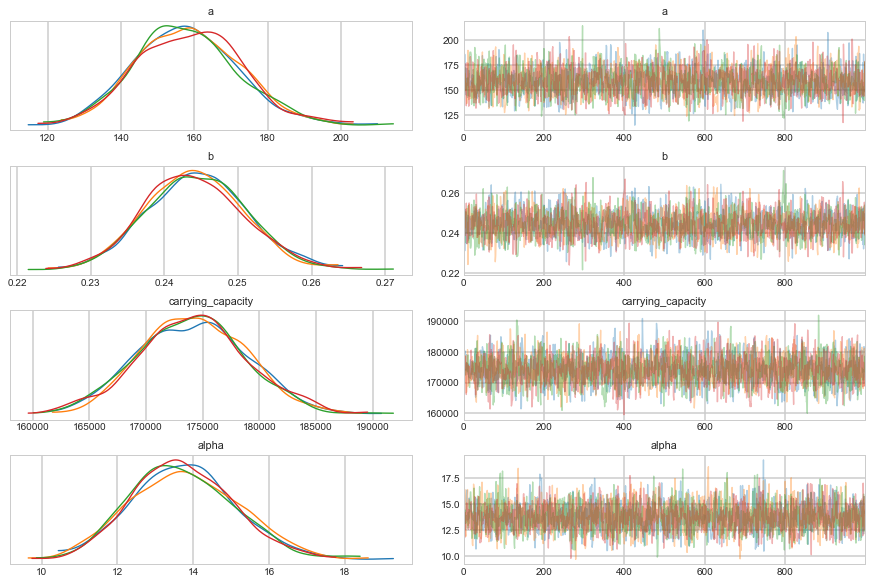

In [70]:
az.plot_trace(trace_logistic);

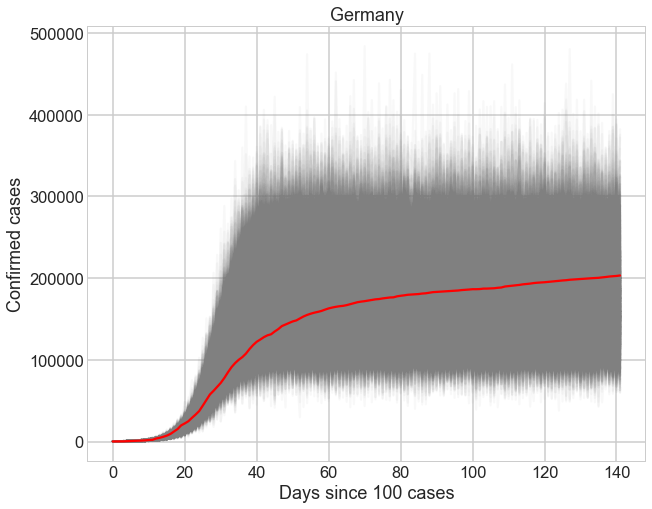

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['obs'].T, color='0.5', alpha=.05)
ax.plot(df_confirmed.values, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       title=country);

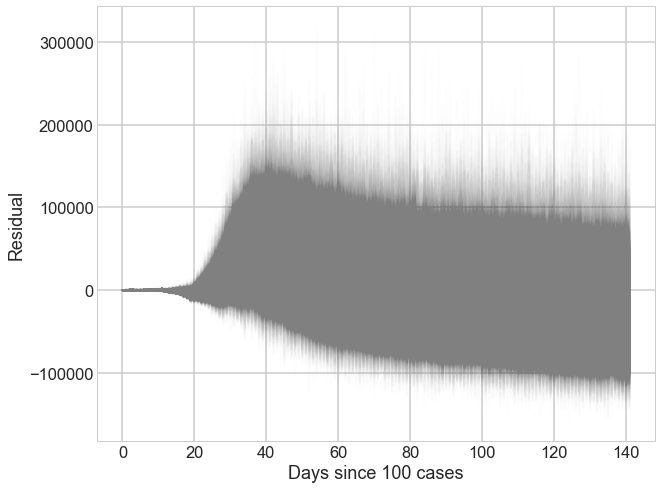

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
resid = post_pred["obs"] - df_confirmed.values
ax.plot(resid.T, color="0.5", alpha=.01);
ax.set(ylabel="Residual",
       xlabel="Days since 100 cases");

What is the difference between the residuals from before?

#### Model comparison

In order to compare our models we first need to refit with the longer data we now have. Fortunately we can easily swap out the data because these are `pm.Data` now.

In [35]:
with model_exp3:
    pm.set_data({"t": df_country.days_since_100.values,
                 "confirmed": df_country.confirmed.values})
    
    trace_exp3_full = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, a]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 71 seconds.


In [36]:
az.compare({"exp3": trace_exp3_full, 
            "logistic": trace_logistic})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
logistic,0,-254.403,0.398315,0,0.999904,11.7429,0,False,log
exp3,1,-265.233,1.35035,10.8298,9.57884e-05,10.5139,2.28629,False,log


As you can see, the logistic model provides a much better fit to the data. 

Although there is still some small bias in the residuals but overall we might think our model is quite good. Let's see how it does on a different country.

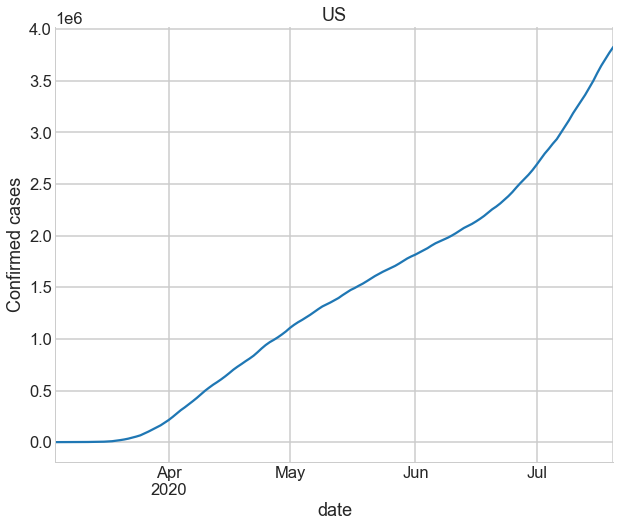

In [16]:
country = 'US'
df_country = df.loc[lambda x: (x.country == country)]
df_confirmed = df_country["confirmed"]
fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()

As you can see, the data looks quite different. Let's see how our logistic model fits this.

In [23]:
df_confirmed = df.loc[lambda x: (x.country == country), 'confirmed']

with pm.Model() as logistic_model:
    t_data = pm.Data('t', df_country.days_since_100.values)
    confirmed_data = pm.Data('confirmed', df_country.confirmed.values)

    # Intercept
    BoundNormal_100 = pm.Bound(pm.Normal, lower=100)
    intercept = BoundNormal_100('a', mu=100, sigma=25)
    
    # Slope
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    b = BoundNormal_0('b', mu=0.3, sigma=0.1)
    
    carrying_capacity = pm.Uniform('carrying_capacity',
                                   lower=1_000,
                                   upper=10_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed_data)

In [24]:
with logistic_model:
    trace_logistic_us = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, carrying_capacity, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Already we see some problems with sampling which should make us suspicious that this model might not be the best for this data.

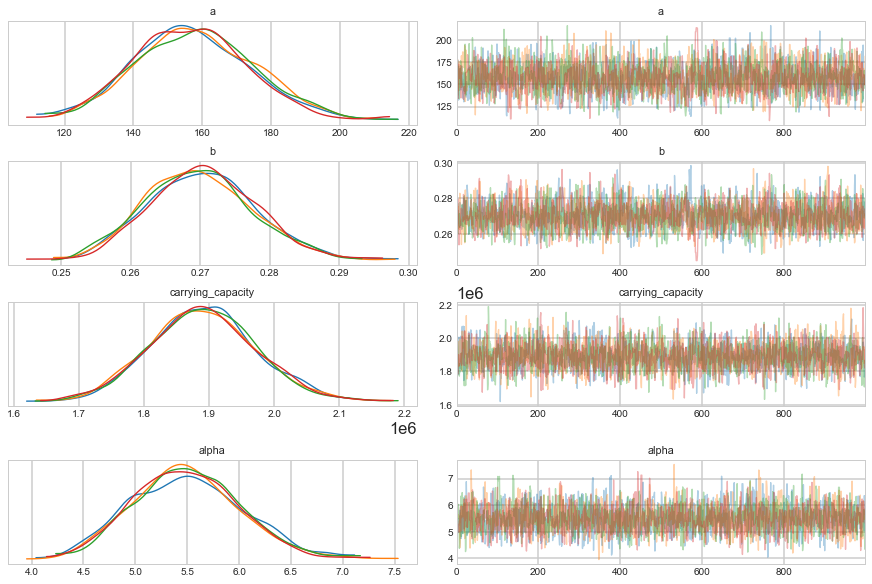

In [25]:
az.plot_trace(trace_logistic_us);

In [26]:
with logistic_model:
    post_pred = pm.sample_posterior_predictive(
        trace_logistic_us.posterior, samples=200)

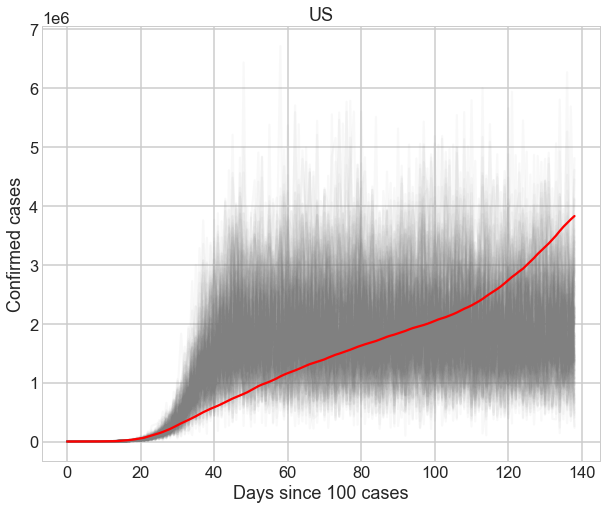

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['obs'].T, color='0.5', alpha=.05)
ax.plot(df_confirmed.values, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       title=country);

As you can see, the model is not a great fit to this data. Why? What assumptions does the model make about the spread of COVID-19?